# Unidimensional

In [56]:
import numpy as np
import matplotlib.pyplot as plt


def compute_mse_vs_n_no_intercept(
    N=200,
    train_fraction=0.8,
    noise_std=0.5,
    true_slope=2.0,
    true_intercept=0.0,  # data may still have an intercept, but the *model* won't
    x_min=0.1,
    x_max=5.0,
    seed=42,
):
    """
    Generate synthetic data: y = true_slope * x + true_intercept + noise
    Then split into train/test, and for n in 1..(train set size),
    fit a linear model y_pred = w * x  (no intercept).

    Returns:
      train_losses, test_losses
        - Arrays (length = # training points), containing the MSE on
          the training subset of size n and on the test set, respectively.
    """
    np.random.seed(seed)

    # 1. Generate data
    X = np.linspace(x_min, x_max, N)  # shape: (N,)
    noise = np.random.normal(loc=0.0, scale=noise_std, size=N)
    y = true_slope * X + true_intercept + noise

    # Make X a 2D array of shape (N,1) for least_squares, but do NOT augment with ones
    X = X.reshape(-1, 1)  # shape (N,1)

    # 2. Shuffle
    indices = np.arange(N)
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    # 3. Train/test split
    split_index = int(train_fraction * N)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # 4. For n = 1..split_index, fit w (one parameter)
    train_losses = []
    test_losses = []

    for n in range(1, split_index + 1):
        X_sub = X_train[:n]
        y_sub = y_train[:n]

        # Solve the linear system in the least-squares sense:
        #   minimize over w: sum_i (y_sub[i] - w * X_sub[i])^2
        # which is done by np.linalg.lstsq
        # w will be shape (1,)
        w, _, _, _ = np.linalg.lstsq(X_sub, y_sub, rcond=None)

        # Predict on the training subset and test set
        y_pred_train = X_sub @ w  # shape (n,)
        y_pred_test = X_test @ w  # shape (N - n,)

        # Compute MSE
        train_mse = np.mean((y_sub - y_pred_train) ** 2)
        test_mse = np.mean((y_test - y_pred_test) ** 2)

        train_losses.append(train_mse)
        test_losses.append(test_mse)

    return np.array(train_losses), np.array(test_losses)

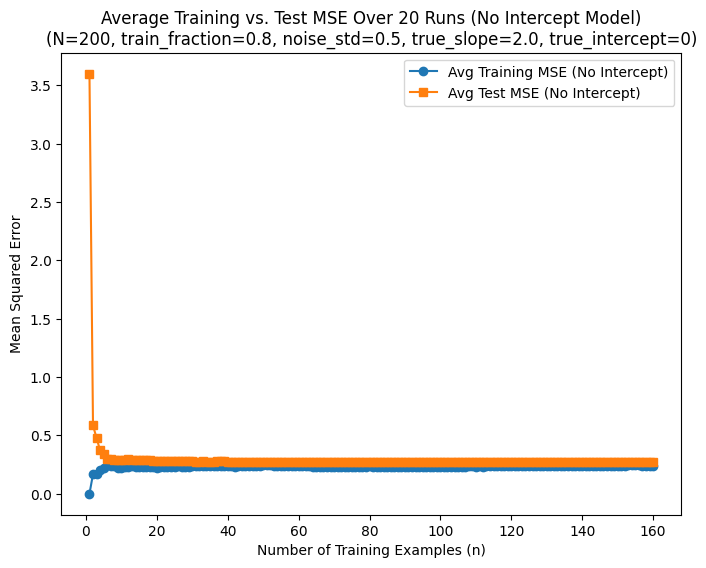

In [57]:
############################################
# USER-CONTROLLED PARAMETERS
############################################
N = 200  # total data points
train_fraction = 0.8  # fraction of data for training
noise_std = 0.5  # noise standard deviation
true_slope = 2.0
true_intercept = 0  # data might have an intercept, but model won't
x_min = 0.1
x_max = 5.0
num_runs = 20  # repeat experiment with different seeds

############################################
# 1) RUN ONCE to know the length
############################################
train_losses_1, test_losses_1 = compute_mse_vs_n_no_intercept(
    N=N,
    train_fraction=train_fraction,
    noise_std=noise_std,
    true_slope=true_slope,
    true_intercept=true_intercept,
    x_min=x_min,
    x_max=x_max,
    seed=0,
)

n_train = len(train_losses_1)  # how many training sizes we tested
acc_train_losses = np.zeros(n_train)
acc_test_losses = np.zeros(n_train)

############################################
# 2) ACCUMULATE over multiple runs
############################################
for run_id in range(num_runs):
    train_losses, test_losses = compute_mse_vs_n_no_intercept(
        N=N,
        train_fraction=train_fraction,
        noise_std=noise_std,
        true_slope=true_slope,
        true_intercept=true_intercept,
        x_min=x_min,
        x_max=x_max,
        seed=run_id,  # different seed per run
    )
    acc_train_losses += train_losses
    acc_test_losses += test_losses

# Compute average MSEs
avg_train_losses = acc_train_losses / num_runs
avg_test_losses = acc_test_losses / num_runs

############################################
# 3) PLOT RESULTS
############################################
plt.figure(figsize=(8, 6))
plt.plot(
    range(1, n_train + 1),
    avg_train_losses,
    label="Avg Training MSE (No Intercept)",
    marker="o",
)
plt.plot(
    range(1, n_train + 1),
    avg_test_losses,
    label="Avg Test MSE (No Intercept)",
    marker="s",
)
plt.xlabel("Number of Training Examples (n)")
plt.ylabel("Mean Squared Error")
plt.title(
    (
        f"Average Training vs. Test MSE Over {num_runs} Runs (No Intercept Model)\n"
        f"(N={N}, train_fraction={train_fraction}, noise_std={noise_std}, "
        f"true_slope={true_slope}, true_intercept={true_intercept})"
    )
)
plt.legend()
plt.show()

# Multidimensional

In [3]:
import numpy as np
import matplotlib.pyplot as plt


def compute_mse_vs_n_no_intercept_multi(
    N=200,  # total number of samples
    d=5,  # dimension of input x
    train_fraction=0.8,
    noise_std=0.5,
    w_true=None,  # if None, we'll randomly generate one
    x_min=0.0,
    x_max=1.0,
    seed=42,
):
    """
    Generates synthetic data in d-dimensional space with no intercept (unless w_true has an intercept component).
    We'll fit a model y_pred = w^T x (no intercept).

    Args:
      N              : total number of samples
      d              : dimension of input features
      train_fraction : fraction of data used for training
      noise_std      : standard deviation of noise
      w_true         : true weight vector (1D array of length d). If None, we'll sample a random vector.
      x_min, x_max   : range over which we sample X from uniform distribution
      seed           : random seed for reproducibility

    Returns:
      train_losses, test_losses : 1D arrays (length = number of training subset sizes)
    """
    # ---------------------
    # 1) Generate Synthetic Data
    # ---------------------
    np.random.seed(seed)

    # If user didn't provide w_true, randomly generate a d-dimensional vector
    if w_true is None:
        w_true = np.random.uniform(low=-1.0, high=1.0, size=d)  # shape (d,)

    # X ~ Uniform(x_min, x_max) in each dimension => shape (N, d)
    X = np.random.uniform(low=x_min, high=x_max, size=(N, d))

    # y = X * w_true + noise
    noise = np.random.normal(loc=0.0, scale=noise_std, size=N)
    # (N,) = (N,d) dot (d,) + (N,)
    y = X.dot(w_true) + noise

    # ---------------------
    # 2) Shuffle & Split
    # ---------------------
    indices = np.arange(N)
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    split_index = int(train_fraction * N)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # ---------------------
    # 3) For n in 1..split_index, fit model & measure MSE
    # ---------------------
    train_losses = []
    test_losses = []

    for n in range(1, split_index + 1):
        # Use the first n points from the training set
        X_sub = X_train[:n]
        y_sub = y_train[:n]

        # Solve the least-squares problem to get w (shape (d,))
        # Minimize sum_i (y_i - w^T x_i)^2
        # np.linalg.lstsq returns (w, residuals, rank, s)
        w_hat, _, _, _ = np.linalg.lstsq(X_sub, y_sub, rcond=None)

        # Predictions on training subset
        y_pred_train = X_sub.dot(w_hat)  # shape (n,)
        train_mse = np.mean((y_sub - y_pred_train) ** 2)

        # Predictions on test set
        y_pred_test = X_test.dot(w_hat)
        test_mse = np.mean((y_test - y_pred_test) ** 2)

        train_losses.append(train_mse)
        test_losses.append(test_mse)

    return np.array(train_losses), np.array(test_losses)

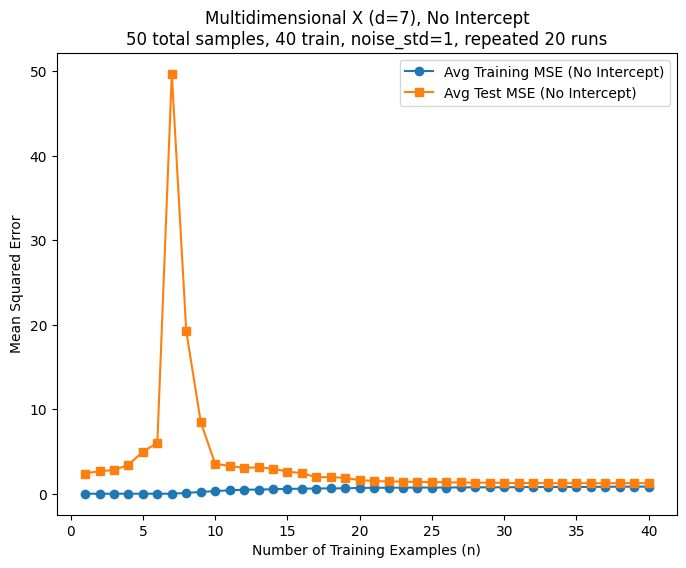

[ 2.38528746  2.68910651  2.78903199  3.42474924  4.97055005  6.02219595
 49.71510738 19.25911328  8.50302529  3.54260779  3.2901009   3.05664589
  3.12346686  2.97049453  2.60951829  2.44383286  1.94333109  1.98363914
  1.85283388  1.61854589  1.49906854  1.4528373   1.43165287  1.37993147
  1.38591139  1.35178789  1.33554537  1.30710471  1.3069479   1.29396911
  1.2593395   1.27087665  1.24750246  1.24207332  1.25709192  1.24609809
  1.24743874  1.24783153  1.25452626  1.24851793]
[2.54530901e-31 7.31333378e-31 1.25686268e-30 2.70385157e-30
 3.82676117e-30 2.47938764e-30 1.68735431e-29 8.92248787e-02
 2.15916437e-01 3.11143929e-01 4.05003608e-01 4.76128787e-01
 4.91247816e-01 5.36835916e-01 5.64148895e-01 5.98993285e-01
 6.13750584e-01 6.38305636e-01 6.36237370e-01 6.84461664e-01
 6.96066745e-01 7.16503719e-01 7.14864690e-01 7.35229768e-01
 7.27078918e-01 7.33065332e-01 7.49861125e-01 7.57300109e-01
 7.62036102e-01 7.62534904e-01 7.76903093e-01 7.98096237e-01
 7.97857463e-01 8.000466

In [16]:
# ---------------------
# Hyperparameters
# ---------------------
N = 50  # total samples
d = 7 # dimension of x
num_runs = 20  # how many times we repeat the experiment
train_fraction = 0.8
noise_std = 1
x_min, x_max = 0.0, 2.0

# Optionally define a "true" w vector
# e.g. w_true = np.array([1.0, -2.0, 0.5, 2.0, -1.0]) if you want a known pattern
# If None, it will be generated randomly for each run.
w_true = None

# ---------------------
# First run - get length of train_losses
# ---------------------
train_losses_1, test_losses_1 = compute_mse_vs_n_no_intercept_multi(
    N=N,
    d=d,
    train_fraction=train_fraction,
    noise_std=noise_std,
    w_true=w_true,
    x_min=x_min,
    x_max=x_max,
    seed=0,  # just a test
)

n_train = len(train_losses_1)  # how many distinct n values we used
acc_train_losses = np.zeros(n_train)
acc_test_losses = np.zeros(n_train)

# ---------------------
# Multiple runs (different seeds)
# ---------------------
for run_id in range(num_runs):
    train_losses, test_losses = compute_mse_vs_n_no_intercept_multi(
        N=N,
        d=d,
        train_fraction=train_fraction,
        noise_std=noise_std,
        w_true=w_true,
        x_min=x_min,
        x_max=x_max,
        seed=run_id,
    )
    acc_train_losses += train_losses
    acc_test_losses += test_losses

# ---------------------
# Average over the runs
# ---------------------
avg_train_losses = acc_train_losses / num_runs
avg_test_losses = acc_test_losses / num_runs

# ---------------------
# Plot
# ---------------------
plt.figure(figsize=(8, 6))
x_axis = np.arange(1, n_train + 1)  # from 1..n_train
plt.plot(
    x_axis, avg_train_losses, label="Avg Training MSE (No Intercept)", marker="o"
)
plt.plot(x_axis, avg_test_losses, label="Avg Test MSE (No Intercept)", marker="s")
plt.xlabel("Number of Training Examples (n)")
plt.ylabel("Mean Squared Error")
plt.title(
    f"Multidimensional X (d={d}), No Intercept\n"
    f"{N} total samples, {int(train_fraction*N)} train, noise_std={noise_std}, repeated {num_runs} runs"
)
plt.legend()
plt.show()

print(avg_test_losses)
print(avg_train_losses)